## 将已筛选好的公司分类
- 高位
- 低位
- 上升期
- 下降期

In [1]:
import sys
sys.path.append("..")

In [2]:
import usefulFuncs as uf

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import scipy.signal as signal
from random import sample
from scipy.stats.mstats import winsorize

In [4]:
diff = pd.read_excel("temp58Good.xlsx")

In [5]:
diff.head()

,code,name,2002-09,2002-12,2003-03,2003-06,2003-09,2003-12,2004-03,2004-06,...,2018-06,2018-09,2018-12,2019-03,2019-06,2019-09,2019-12,2020-03,2020-06,2020-09
0,000039.SZ,中集集团,NaN,1.5694,0.4317,0.8289,2.3985,-0.5915,-0.16150,5.5439,...,0.6702,2.5957,-0.7514,-0.3023,-0.9204,-4.4060,-0.7144,-2.7070,0.4466,2.2684
1,000157.SZ,中联重科,NaN,0.7925,0.6252,-0.0530,2.3187,1.3187,5.05948,3.4208,...,-1.5265,0.7731,1.7620,1.5942,2.8336,1.2361,0.4303,0.0100,2.9604,1.2673
2,000425.SZ,徐工机械,NaN,NaN,-0.1752,1.7709,-0.9148,-0.8298,-0.04350,-1.1708,...,0.6946,0.5232,0.8467,1.2977,1.5365,0.7489,-0.0338,-1.6140,0.3198,-1.1808
3,000528.SZ,柳工,NaN,NaN,4.2449,3.9909,1.8239,-1.9508,3.50290,-1.2512,...,1.7661,0.8576,0.3048,-0.0064,0.3567,0.9474,0.5408,-1.5118,1.1505,0.6874
4,000584.SZ,哈工智能,NaN,NaN,0.1018,-0.2111,0.2614,3.6415,1.07720,1.1521,...,-1.4110,0.6145,-0.5203,-0.9230,-1.0394,-1.2613,-1.7084,-1.3093,-2.1302,-1.1252


In [6]:
codes = diff.code.values
codes

array(['000039.SZ', '000157.SZ', '000425.SZ', '000528.SZ', '000584.SZ',
       '000680.SZ', '000821.SZ', '000852.SZ', '000856.SZ', '000976.SZ',
       '002006.SZ', '002009.SZ', '002073.SZ', '002097.SZ', '002132.SZ',
       '002150.SZ', '002158.SZ', '002164.SZ', '002248.SZ', '002272.SZ',
       '002278.SZ', '002337.SZ', '002366.SZ', '002430.SZ', '002438.SZ',
       '002490.SZ', '002520.SZ', '002526.SZ', '300024.SZ', '300080.SZ',
       '300084.SZ', '300091.SZ', '300092.SZ', '300099.SZ', '300126.SZ',
       '300161.SZ', '600031.SH', '600169.SH', '600218.SH', '600302.SH',
       '600320.SH', '600375.SH', '600388.SH', '600481.SH', '600499.SH',
       '600501.SH', '600520.SH', '600528.SH', '600582.SH', '600761.SH',
       '600835.SH', '600843.SH', '600984.SH', '601002.SH', '601106.SH',
       '900924.SH', '900925.SH', '900947.SH'], dtype=object)

柳工 000528.SZ
太原重工 600169.SH
中铁工业 600528.SH


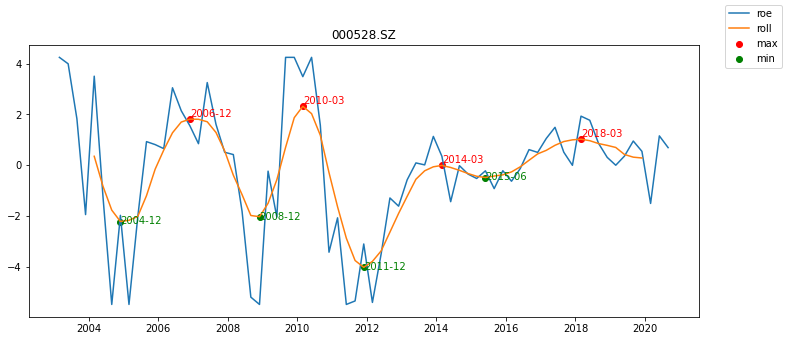

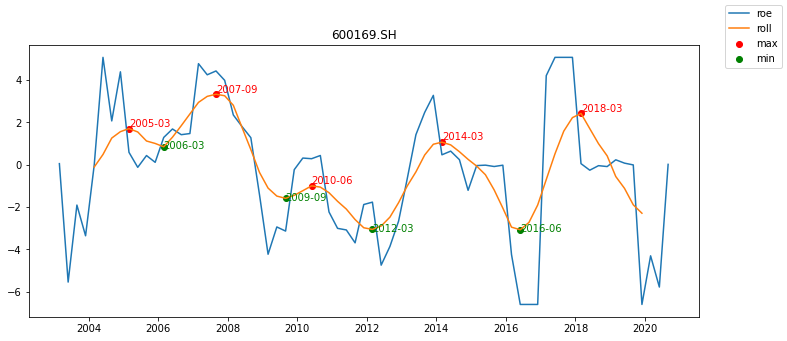

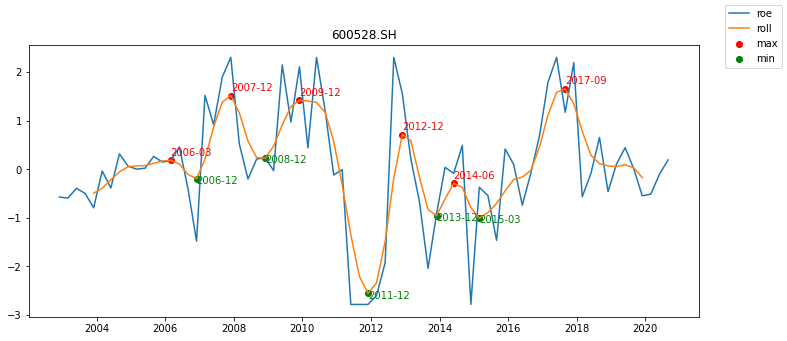

In [7]:
# for code in codes:
#     name = uf.getNameByCode(code, diff)
#     print(name, code)
#     uf.showOne(code, diff)
for code in np.random.choice(codes, size=3):
    name = uf.getNameByCode(code, diff)
    print(name, code)
    uf.showOne(code, diff)

### 分类
思路
- 时间跨度或者值跨度

#### 时间跨度
- 计算平均周期的期限 t
- 计算现在离最近极点的时间距离 
- 最近一次是极大值，则为高位或下降
- 最近一次是极小值，则为低位或上升
- 根据时间跨度占平均期限的比例来判断是低位还是上升

#### 值跨度
拿roe的数据不是rolling的数据比较？
- 计算极值相差的均值
- 计算最近yRolling值和极值的差值
- 如果相邻极值为极小值
    - 差值为负则为下降？ 是否存在这种情况
    - 差值为正，低位或上升
- 如果相邻极值为极大值
    - 差值为正则为上升？
    - 差值为负，高位或下降，根据差值大小和均值的关系判断

主要思路 pseudocode
```python
get pExtr, last extreme point
get pRoll, last point on yRolling
get pRoe, last point on raw roe Data
if isMin(pExtr, minimum):
    # is minimum
    # 判断是否是上升趋势，如果是下降趋势，则抛出异常
    if pRoll<pExtr:
        raise ValueError("异常")
    # pRoll > pExtr
    if pRoe>pRoll:
        increase
    elif pRoe<pExtr:
        Low
    else:
        # 中间
        increase?
else:
    # is maximum
    if pRoll>pExtr:
        raise ValueError("异常")
    # pRoll<pExtr
    if pRoe<pRoll:
        decrease
    elif pRoe>pExtr:
        high
    else:
        decrease?
```

In [8]:
code = "000821.SZ"
name = uf.getNameByCode(code, diff)
company, y = uf.getCompanyByCode(code, diff)
yRolling = uf.getYRolling(y)
maxIdx, minIdx = uf.getExtreme(yRolling)
maximum, minimum = yRolling[maxIdx], yRolling[minIdx]

In [9]:
# 值跨度
minMax = pd.concat([maximum, minimum]).sort_index()
# minMax = np.abs(minMax.diff(1))  # 相邻极值点的差值
# minMax = minMax[~minMax.isnull()]
# avgVSpan = np.average(minMax)  # average value span
# print(avgVSpan)
# print(minMax)

In [10]:
latestExtreme = minMax[-1]  # 最后一个极值点
latestPoint = yRolling[~yRolling.isnull()][-1]  # 最后一个点
latestPointRoe = company.iloc[0, -1]  # roe 数据中最后一个点
latestDiff = latestPoint - latestExtreme

In [11]:
name

'京山轻机'

In [12]:
latestExtreme

0.9870734721425855

In [13]:
latestExtreme == maximum[-1]

True

In [14]:
uf.markCompany(latestExtreme, latestPoint, latestPointRoe, minimum)

'H'

In [16]:
df = uf.markCompanies(diff)
df.to_excel("marked.xlsx", index=False)

## 检查正确性
画图检查